In [151]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import base
import matplotlib.pyplot as plt
%matplotlib inline

## Business Understanding

The dataset will be used to address three questions of interest to potential Kickstarter project creators:

1. Are large initial goals detrimental to project success?
2. Is there any indication of a common set of terms used to name different projects in different categories? Are some categories more likely to have common terms than others?
3. Can the success of a project be predicted only given a projects name, or only with the name and other information available at the start (category, goal, etc.)

## Data Understanding

First some intial investigation of the database provides indications on which columns are important

In [2]:
data = pd.read_csv('ks-projects-201801.csv')
data.head(10)

ID                                               name  \
0  1000002330                    The Songs of Adelaide & Abullah   
1  1000003930      Greeting From Earth: ZGAC Arts Capsule For ET   
2  1000004038                                     Where is Hank?   
3  1000007540  ToshiCapital Rekordz Needs Help to Complete Album   
4  1000011046  Community Film Project: The Art of Neighborhoo...   
5  1000014025                               Monarch Espresso Bar   
6  1000023410  Support Solar Roasted Coffee & Green Energy!  ...   
7  1000030581  Chaser Strips. Our Strips make Shots their B*tch!   
8  1000034518  SPIN - Premium Retractable In-Ear Headphones w...   
9   100004195  STUDIO IN THE SKY - A Documentary Feature Film...   

         category main_category currency    deadline      goal  \
0          Poetry    Publishing      GBP  2015-10-09    1000.0   
1  Narrative Film  Film & Video      USD  2017-11-01   30000.0   
2  Narrative Film  Film & Video      USD  2013-02-26   45000.0   
3           Music         Music      USD  2012-04-16    5000.0   
4    Film & Video  Film & Video      USD  2015-08-29   19500.0   
5     Restaurants          Food      USD  2016-04-01   50000.0   
6            Food          Food      USD  2014-12-21    1000.0   
7          Drinks          Food      USD  2016-03-17   25000.0   
8  Product Design        Design      USD  2014-05-29  125000.0   
9     Documentary  Film & Video      USD  2014-08-10   65000.0   

              launched   pledged       state  backers country  usd pledged  \
0  2015-08-11 12:12:28      0.00      failed        0      GB         0.00   
1  2017-09-02 04:43:57   2421.00      failed       15      US       100.00   
2  2013-01-12 00:20:50    220.00      failed        3      US       220.00   
3  2012-03-17 03:24:11      1.00      failed        1      US         1.00   
4  2015-07-04 08:35:03   1283.00    canceled       14      US      1283.00   
5  2016-02-26 13:38:27  52375.00  successful      224      US     52375.00   
6  2014-12-01 18:30:44   1205.00  successful       16      US      1205.00   
7  2016-02-01 20:05:12    453.00      failed       40      US       453.00   
8  2014-04-24 18:14:43   8233.00    canceled       58      US      8233.00   
9  2014-07-11 21:55:48   6240.57    canceled       43      US      6240.57   

   usd_pledged_real  usd_goal_real  
0              0.00        1533.95  
1           2421.00       30000.00  
2            220.00       45000.00  
3              1.00        5000.00  
4           1283.00       19500.00  
5          52375.00       50000.00  
6           1205.00        1000.00  
7            453.00       25000.00  
8           8233.00      125000.00  
9           6240.57       65000.00

In [144]:
data.describe()

ID          goal       pledged        backers   usd pledged  \
count  3.786610e+05  3.786610e+05  3.786610e+05  378661.000000  3.748640e+05   
mean   1.074731e+09  4.908079e+04  9.682979e+03     105.617476  7.036729e+03   
std    6.190862e+08  1.183391e+06  9.563601e+04     907.185035  7.863975e+04   
min    5.971000e+03  1.000000e-02  0.000000e+00       0.000000  0.000000e+00   
25%    5.382635e+08  2.000000e+03  3.000000e+01       2.000000  1.698000e+01   
50%    1.075276e+09  5.200000e+03  6.200000e+02      12.000000  3.947200e+02   
75%    1.610149e+09  1.600000e+04  4.076000e+03      56.000000  3.034090e+03   
max    2.147476e+09  1.000000e+08  2.033899e+07  219382.000000  2.033899e+07   

       usd_pledged_real  usd_goal_real  
count      3.786610e+05   3.786610e+05  
mean       9.058924e+03   4.545440e+04  
std        9.097334e+04   1.152950e+06  
min        0.000000e+00   1.000000e-02  
25%        3.100000e+01   2.000000e+03  
50%        6.243300e+02   5.500000e+03  
75%        4.050000e+03   1.550000e+04  
max        2.033899e+07   1.663614e+08

One thing that immediately jumps out is the fact that for pledged, backers, and goal there are three or more orders of magnitude difference between the 75% level and the max, indicating a very schewed dataset.

As the goal here is to analyze the titles, it is possible that British vs American spellings can create confusion. For the purposes of this dataset, the two will be treated separately. 

In [3]:
data_US = data[data['country'] == 'US']
data_GB = data[data['country'] == 'GB']

In [4]:
data_US.head(10)

ID                                               name  \
1   1000003930      Greeting From Earth: ZGAC Arts Capsule For ET   
2   1000004038                                     Where is Hank?   
3   1000007540  ToshiCapital Rekordz Needs Help to Complete Album   
4   1000011046  Community Film Project: The Art of Neighborhoo...   
5   1000014025                               Monarch Espresso Bar   
6   1000023410  Support Solar Roasted Coffee & Green Energy!  ...   
7   1000030581  Chaser Strips. Our Strips make Shots their B*tch!   
8   1000034518  SPIN - Premium Retractable In-Ear Headphones w...   
9    100004195  STUDIO IN THE SKY - A Documentary Feature Film...   
11   100005484                                   Lisa Lim New CD!   

          category main_category currency    deadline      goal  \
1   Narrative Film  Film & Video      USD  2017-11-01   30000.0   
2   Narrative Film  Film & Video      USD  2013-02-26   45000.0   
3            Music         Music      USD  2012-04-16    5000.0   
4     Film & Video  Film & Video      USD  2015-08-29   19500.0   
5      Restaurants          Food      USD  2016-04-01   50000.0   
6             Food          Food      USD  2014-12-21    1000.0   
7           Drinks          Food      USD  2016-03-17   25000.0   
8   Product Design        Design      USD  2014-05-29  125000.0   
9      Documentary  Film & Video      USD  2014-08-10   65000.0   
11      Indie Rock         Music      USD  2013-04-08   12500.0   

               launched   pledged       state  backers country  usd pledged  \
1   2017-09-02 04:43:57   2421.00      failed       15      US       100.00   
2   2013-01-12 00:20:50    220.00      failed        3      US       220.00   
3   2012-03-17 03:24:11      1.00      failed        1      US         1.00   
4   2015-07-04 08:35:03   1283.00    canceled       14      US      1283.00   
5   2016-02-26 13:38:27  52375.00  successful      224      US     52375.00   
6   2014-12-01 18:30:44   1205.00  successful       16      US      1205.00   
7   2016-02-01 20:05:12    453.00      failed       40      US       453.00   
8   2014-04-24 18:14:43   8233.00    canceled       58      US      8233.00   
9   2014-07-11 21:55:48   6240.57    canceled       43      US      6240.57   
11  2013-03-09 06:42:58  12700.00  successful      100      US     12700.00   

    usd_pledged_real  usd_goal_real  
1            2421.00        30000.0  
2             220.00        45000.0  
3               1.00         5000.0  
4            1283.00        19500.0  
5           52375.00        50000.0  
6            1205.00         1000.0  
7             453.00        25000.0  
8            8233.00       125000.0  
9            6240.57        65000.0  
11          12700.00        12500.0

In [5]:
data_US.shape

(292627, 15)

In [6]:
data_GB.shape

(33672, 15)

First some initial data exploration.

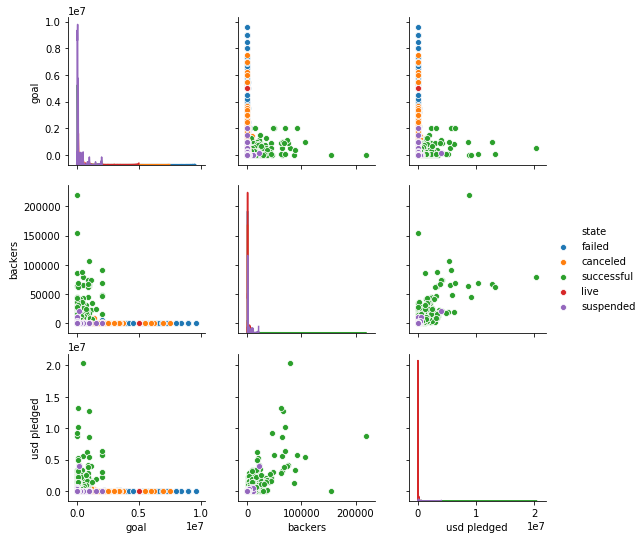

In [88]:
"""
g = sns.pairplot(data_US[['goal', 'backers', 'usd pledged', 'state']], hue='state',diag_kind='kde')
for i in range(0, len(g.axes)):
    for j in range(0, len(g.axes[0])):
        g.axes[i,j].set(yscale='log', xscale='log')
"""
sns.pairplot(data_US[data_US['goal'] < 1e7][['goal', 'backers', 'usd pledged', 'state']], hue='state',diag_kind='kde')
plt.savefig('pairplot.png', dpi=300)
plt.show()

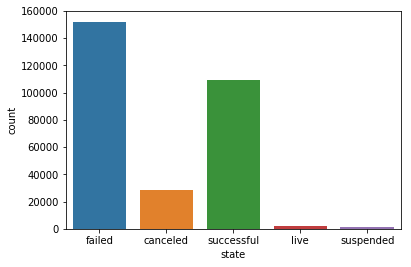

In [8]:
sns.countplot(data_US['state'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

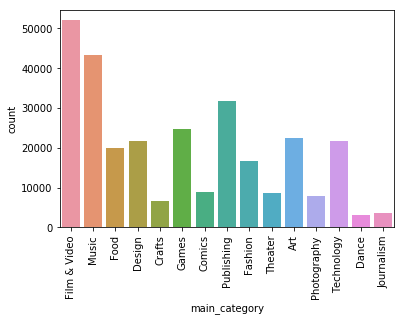

In [7]:
sns.countplot(data_US['main_category'])
plt.xticks(rotation=90)

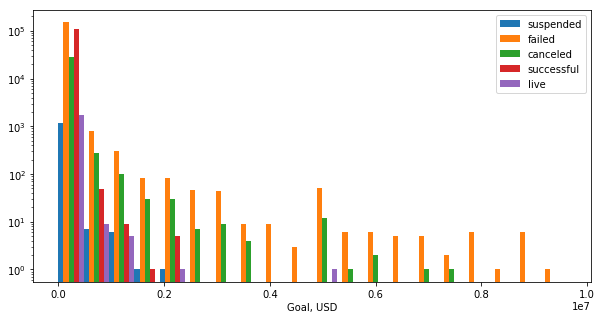

In [93]:
colors = ['red', 'green', 'blue', 'orange', 'purple']
i = 0
plt.figure(figsize=(10,5))
lists = []
data_cut = data_US[data_US['goal'] < 1e7][['goal', 'backers', 'usd pledged', 'state']]
for state in set(data_US['state']):
    lists.append(data_cut[data_cut['state'] == state]['goal'].tolist())
    i += 1
plt.hist(lists, bins=20, label=list(set(data_US['state'])), rwidth=1)
plt.legend()
plt.yscale('log')
plt.xlabel('Goal, USD')
plt.savefig('Goal_hist.png', dpi=300)
plt.show()

In [95]:
data_cut.shape[0]/data_US.shape[0]

0.9994976540100537

It appears that for the numeric columns, there are severe outliers in the data likely revealing overly optimistic projects or runaway successes. The dataset does have a nice distribution of categories. Already it is clear that for the first question, setting goals above ~\$200,000 is not advisable as these projects are rarely succesful. 

## Data Preparation

### Predicting categories from LSA

First, the names have to be converted to a useful numeric dataset. To do this a TFIDF vectorizer is used.

In [6]:
lower = lambda x: x.lower() if type(x) == str else x
data_US['lower'] = [lower(x) for x in data_US['name']] # make all titles lowercase

C:\Users\rwalr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
data_US['lower']

1             greeting from earth: zgac arts capsule for et
2                                            where is hank?
3         toshicapital rekordz needs help to complete album
4         community film project: the art of neighborhoo...
5                                      monarch espresso bar
6         support solar roasted coffee & green energy!  ...
7         chaser strips. our strips make shots their b*tch!
8         spin - premium retractable in-ear headphones w...
9         studio in the sky - a documentary feature film...
11                                         lisa lim new cd!
12                                       the cottage market
13        g-spot place for gamers to connect with eachot...
15                                           survival rings
16                                                the beard
17                         notes from london: above & below
18                      mike corey's darkness & light album
19                                      

In [99]:
# stop words are chosen based on the standard 'english' list, but with a few removed such as gendered pronouns which might be 
# important
stopwords = ['between', 'yourself', 'but', 'again', 'there', 'about', 'once', 'during', 'out', 'very', 
             'having', 'with', 'an', 'be', 'some', 'for', 'do', 'its', 'such', 'into', 'of', 'most', 
             'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'each', 'the', 'themselves', 'until', 
             'below', 'are', 'these', 'through', 'don', 'nor', 'were', 'more', 
             'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'all', 'no', 
             'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 
             'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'you', 
             'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 
             'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than']

In [13]:
data_US.shape

(292627, 16)

Since there are very few NaN values, they are just dropped for the name column.

In [102]:
data_US = data_US.dropna(subset=['name'])

In [103]:
countvector = TfidfVectorizer(stop_words=stopwords)

In [104]:
bow_US = countvector.fit_transform(data_US['name'])

C:\Users\rwalr\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [11]:
len(countvector.get_feature_names())/data_US.shape[0]

0.38858740226365573

In [12]:
bow_US.shape

(292624, 113710)

Given the huge size of the term frequencies, it was decided to use TruncatedSVD for feature extraction.

In [105]:
tsvd = TruncatedSVD(n_components=200)
tsvd.fit(bow_US)

TruncatedSVD(algorithm='randomized', n_components=200, n_iter=5,
       random_state=None, tol=0.0)

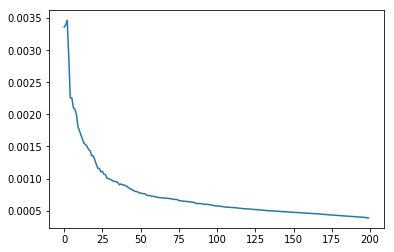

In [73]:
plt.plot(tsvd.explained_variance_ratio_)

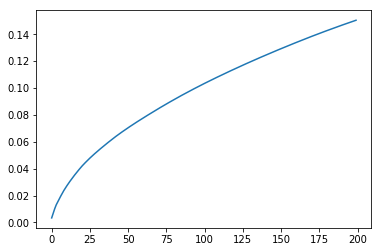

In [74]:
plt.plot(tsvd.explained_variance_ratio_.cumsum())

In this case, TruncatedSVD was used (also called LSA for text data) in order to get visualizations and to do the eventual machine learning. 

In [106]:
lsa = tsvd.transform(bow_US)
lsa[0].shape

(200,)

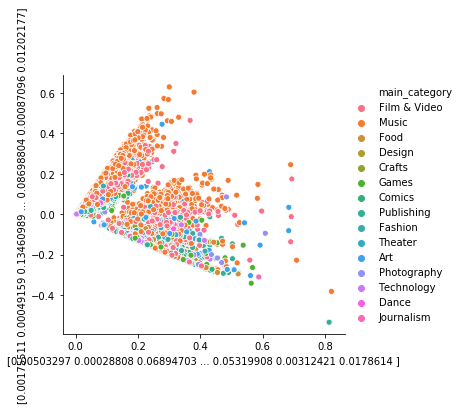

In [22]:
sns.relplot(x=lsa[:,0], y=lsa[:,1], hue=data_US['main_category'], data=data_US)

In [158]:
#Making a function for generating LSA in one step:
def Get_LSA(data, n_comp=200):
    """
    Function to perform LSA on dataset. Takes in corpus and returns the truncated svd instance and the LSA.
    n_comp is the number of LSA components to output.
    """
    countvector = TfidfVectorizer(stop_words=stopwords)
    bow = countvector.fit_transform(data)
    tsvd = TruncatedSVD(n_components=n_comp)
    tsvd.fit(bow)
    lsa = tsvd.transform(bow)
    return tsvd, lsa

In [116]:
data_US.shape
len(set(data_US['main_category']))
cmap(0.1)

(0.282623, 0.140926, 0.457517, 1.0)

In [118]:
cmap = plt.cm.viridis
colors = []
for i, cat in enumerate(set(data_US['main_category'])):
    for j in data_US['main_category']:
        if j == cat:
            colors.append(cmap(i/15))
    

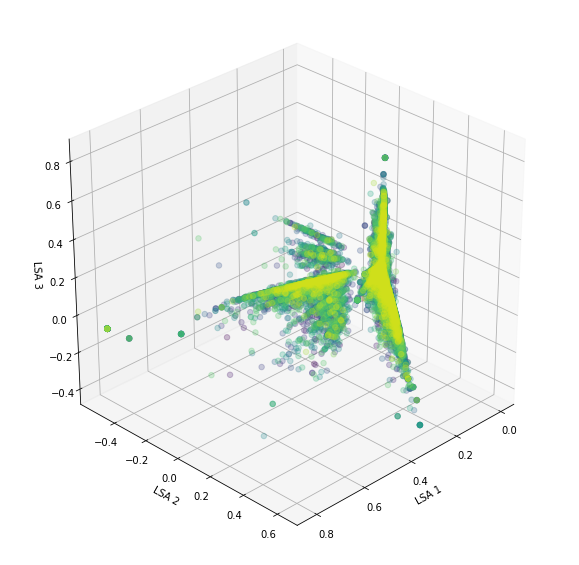

In [124]:
# libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Dataset
# plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lsa[:,0], lsa[:,1], lsa[:,2], c=colors, s=30, alpha=0.25)
ax.set_xlabel('LSA 1')
ax.set_ylabel('LSA 2')
ax.set_zlabel('LSA 3')
ax.view_init(30, 45)
plt.savefig('LSAPlot.png', dpi=300)
plt.show()


In [146]:
data_US.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

The other columns in the database still need to be treated:
* ID: dropped, just an index
* category, main_category: These will be converted to dummy variables as they are categorical columns. There is a relationship between category and main_category, but both will be kept for further analysis. 
* currency: dropped, projects have already been separated by country.
* deadline: dropped, deadlines are always 30 days after the launched date, and so only the launched date column is kept.
* goal: will be kept as is. Dropping outliers was initially considered, but rejected.
* launched: converted to ordinal. It is possible certain projects will be trying to cash in on fads, so it makes sense to preserve information on which projects were launched before others. 
* pledged: as this column represents data not available to creators until after the project is done, it will be dropped.
* state: these are the labels to be predicted
* backers: see pledged
* country: see currency
* usd_pledged, usd_pledged_real: see pledged.
* usd_goal_real: duplicate of goal for US data, and UK data will always be treated separately. 

In [147]:
# Drop the columns we don't want
X = data_US[['category', 'main_category', 'goal', 'launched']].copy()
y = data_US['state']

print('Turn category and main_category into dummy variables')

for x in ('category', 'main_category'):
    dummies = pd.get_dummies(X[x])
    X = pd.concat((X.drop(x, axis=1),dummies), axis=1)

print ('turn launched into ordinal')
toordinal = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").toordinal()
X['launched'] = [toordinal(x) for x in X['launched']]

print ('scale the data')
X = pd.DataFrame(StandardScaler().fit_transform(X), index=data_US.index)

print(X.shape)

Turn category and main_category into dummy variables
turn launched into ordinal
scale the data
(292624, 176)


In [160]:
# Once trouble shot, the above was incorporated into a single function
def data_prep(data, do_lsa=True):
    """
    Function to prepare data for machine learning algorithms. LSA is optional. Drops nan values for
    the name column, converts categories to dummy variables, and dates to ordinal variables.
    """
    data_out = data.dropna(subset=['name'])
    
    if do_lsa:
        tsvd, lsa = Get_LSA(data_out['name'])
    
    X = data_out[['category', 'main_category', 'goal', 'launched']].copy()
    y = data_out['state']

    print('Turn category and main_category into dummy variables')

    for x in ('category', 'main_category'):
        dummies = pd.get_dummies(X[x])
        X = pd.concat((X.drop(x, axis=1),dummies), axis=1)

    print ('turn launched into ordinal')
    toordinal = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").toordinal()
    X['launched'] = [toordinal(x) for x in X['launched']]

    print ('scale the data')
    X = pd.DataFrame(StandardScaler().fit_transform(X), index=data_out.index)
    
    if do_lsa:
        print ('add back in the lsa')
        X = pd.concat((X, pd.DataFrame(lsa, index = X.index)), axis=1)
        return X, y, lsa
    
    else:
        return X, y

## Data Modeling

The second question of interest was to what extent are categories predicted by the names of the projects. A RandomForrestClasifier was used as it is farily light computationally.

C:\Users\rwalr\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [127]:
y = data_US['main_category']
X = lsa
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [128]:
from sklearn.ensemble import RandomForestClassifier

In [133]:
model = RandomForestClassifier(n_estimators=20, max_features='auto', min_samples_leaf=10, min_samples_split=20, random_state=42,
                              criterion='entropy')
model.fit(X_train, y_train)

predictions = model.predict(X_test)


In [134]:
from sklearn.metrics import accuracy_score, classification_report

In [135]:
accuracy_score(y_test, predictions)

0.5138454528508999

In [136]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         Art       0.46      0.33      0.38      7324
      Comics       0.81      0.38      0.51      2907
      Crafts       0.49      0.10      0.17      2175
       Dance       0.75      0.31      0.44      1074
      Design       0.41      0.37      0.39      7198
     Fashion       0.62      0.46      0.53      5514
Film & Video       0.41      0.74      0.52     17071
        Food       0.59      0.62      0.60      6618
       Games       0.63      0.54      0.58      8239
  Journalism       0.38      0.01      0.02      1179
       Music       0.70      0.72      0.71     14271
 Photography       0.67      0.19      0.30      2670
  Publishing       0.46      0.42      0.44     10410
  Technology       0.47      0.43      0.45      7045
     Theater       0.60      0.28      0.38      2871

 avg / total       0.54      0.51      0.50     96566



A 51% accuracy for an un-optimized model is ok, in the future a  more exhaustive optimization would likely provide better results. For now I will move on to the next point of enquiry, is there any information in the titles which would be related to their success rate. For this, classification will be done as either success or nothing. The LSA features will be used in addition to category and the "goal" column, since these would be known at the start of a campaign.

In [152]:
# A function was written to make the above process quicker
def fit_data(X, y, model):
    """
    Does a train test split, fits the data, and prints out accuracy score and classification report
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    model2 = base.clone(model)
    model2.fit(X_train, y_train)

    predictions = model2.predict(X_test)
    
    print(f"Accuracy: {accuracy_score(y_test, predictions)}")
    
    print("Classification Report\n")
    print(classification_report(y_test, predictions))

### Predicting state from other variables

First, the LSA alone were tested

In [153]:
y = data_US['state']
X = lsa
model = RandomForestClassifier(n_estimators=20, max_features='auto', min_samples_leaf=10, min_samples_split=20, random_state=42,
                              criterion='entropy')
fit_data(X, y, model)

Accuracy: 0.6110846467700847
Classification Report

             precision    recall  f1-score   support

   canceled       1.00      0.63      0.77      9323
     failed       0.60      0.80      0.69     50111
       live       0.00      0.00      0.00       614
 successful       0.54      0.35      0.43     36127
  suspended       0.98      0.55      0.70       391

avg / total       0.61      0.61      0.59     96566



C:\Users\rwalr\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Next, the other data columns were tested on their own (without the LSA)

In [154]:
X, y = data_prep(data_US, do_lsa=False)

fit_data(X, y, model)

Turn category and main_category into dummy variables
turn launched into ordinal
scale the data
Accuracy: 0.6018785079634654
Classification Report

             precision    recall  f1-score   support

   canceled       0.28      0.00      0.01      9323
     failed       0.61      0.77      0.68     50111
       live       0.68      0.88      0.77       614
 successful       0.58      0.52      0.55     36127
  suspended       0.00      0.00      0.00       391

avg / total       0.57      0.60      0.57     96566



C:\Users\rwalr\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Now all the columns together will be used.

In [156]:
X, y, lsa = data_prep(data_US, do_lsa=True)

fit_data(X, y, model)

C:\Users\rwalr\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Turn category and main_category into dummy variables
turn launched into ordinal
scale the data
add back in the lsa
Accuracy: 0.6439326471014643
Classification Report

             precision    recall  f1-score   support

   canceled       1.00      0.62      0.77      9323
     failed       0.63      0.81      0.71     50111
       live       0.85      0.22      0.35       614
 successful       0.60      0.43      0.50     36127
  suspended       0.98      0.53      0.69       391

avg / total       0.66      0.64      0.63     96566



Considering the minimal optimization, a score of 65% is pretty good. Lastly, the GB dataset will be examined

In [161]:
X, y, lsa = data_prep(data_GB, do_lsa=True)

fit_data(X, y, model)

C:\Users\rwalr\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Turn category and main_category into dummy variables
turn launched into ordinal
scale the data
add back in the lsa
Accuracy: 0.6525377969762419
Classification Report

             precision    recall  f1-score   support

   canceled       1.00      0.57      0.73      1226
     failed       0.63      0.85      0.72      5772
       live       1.00      0.05      0.10        76
 successful       0.62      0.40      0.49      3982
  suspended       0.97      0.54      0.69        56

avg / total       0.67      0.65      0.64     11112



## Results and Conclusions

This was a very nice dataset to work with, only having three nan values to get rid of. In terms of answering the questions stated in the beginning, the first concerned how setting a goal for a project would affect the outcome. It was immediately obvious that all the numeric data is strongly right skewed. For the goal column, there were almost no succesful projects with goals above $200,000 dollars. For predicting the category of a project based off of its name, the answer turned out to be extremely varied between categories with Journalism being the hardest to predict while Music was much easier. Finally, the LSA greatly improved the ability of a simple RFC to predict the outcome of a project